## Convolutional Neural Network with Pytorch using CPU and GPU

<img src="images/cnn1.png" width="400" height="500">

### Convolution Multiple Filters

<img src="images/cnn3.png" width="500" height="500">

### Pooling

<img src="images/cnn2.png" width="400" height="500">

### Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import collections
import matplotlib.pyplot as plt
import numpy as np

### Load Datasets

In [2]:
# Get the training data set, train=True
# Make sure data is tesnor, transform=transforms.ToTensor()
# download if doesn't exist, download=True
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

In [3]:
# number of samples in the data set
len(train_dataset)

60000

In [4]:
# load the testing dataset
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [5]:
# number of samples in the data set
len(test_dataset)

10000

In [6]:
batch_size = 100
epochs = 10

In [7]:
accuracy_list = []
epoch_list = []
for i in range(0,epochs):
    epoch_list.append(i)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
isinstance(train_loader, collections.Iterable)

True

In [9]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
isinstance(test_loader, collections.Iterable)

True

### Convolution output size:
<img src="images/cnn4.png" width="250">

### Pooling output size:

- Nout = number of output features
- Nin = number of input features
- K = kernal(filter) size

Nout = Nin / K

## Network Structure

- (Layer 1) 
    - Conv1: Filter size = 5, # filters = 16, Stride = 1, Padding = 2 (same padding)
    - Pool1: Filter size = 2, # filters = 16, Stride = 1
- (Layer 2) 
    - Conv2: Filter size = 5, # filters = 32, Stride = 1, Padding = 2 (same padding)
    - Pool2: Filter size = 2, # filters = 32, Stride = 1

**(28,28) -Conv1> (16,28,28) -Pool1> (16,14,14) -Conv2> (32,14,14) -Pool2> (32,7,7) -FC> (10,1) -Softmax> y**

In [10]:
class CNNModel(nn.Module):
    def __init__ (self):
        super(CNNModel, self).__init__()
        # Layer 1 
        # Convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        # Activation
        self.relu1 = nn.ReLU()
        # Pooling 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Layer 2
        # Convolution
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        # Activation
        self.relu2 = nn.ReLU()
        # Pooling 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully Connected Layer
        # - 10 classes
        # - 32 * 7 * 7 = 1568
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        
        # Layer 1
        out1 = self.conv1(x)
        out1 = self.relu1(out1)
        out1 = self.maxpool1(out1)
        
        # Layer 2
        out2 = self.conv2(out1)
        out2 = self.relu2(out2)
        out2 = self.maxpool2(out2)
        
        # Flattening
        out3 = out2.view(out2.size(0), -1)
        
        # Fully Connected
        out4 = self.fc1(out3)
        
        return out4

In [11]:
use_cuda = True

In [12]:
model = CNNModel()

In [13]:
# move the model to GPU
if torch.cuda.is_available() and use_cuda:
    model.cuda()

In [14]:
loss_function = nn.CrossEntropyLoss()

In [15]:
learning_rate = 0.1

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
# Weights (Kernel/Filter) sizes
print(list(model.parameters())[0].size())
print(list(model.parameters())[1].size())
print(list(model.parameters())[2].size())
print(list(model.parameters())[3].size())
print(list(model.parameters())[4].size())
print(list(model.parameters())[5].size())

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([10, 1568])
torch.Size([10])


In [18]:
def calcuateAccuracy():
    correct = 0
    total = 0
        
    for images, labels in test_loader:
        # get all the images in the training data set
        if torch.cuda.is_available() and use_cuda:
            #move torch tensors to the GPU
            images = Variable(images.cuda())
        else:
            images = Variable(images)
        
        # get all the predictions for each class using the model
        all_predictions = model(images)
            
        # highest is the final prediction
        _, predictions = torch.max(all_predictions.data, 1)
       
        # total number of samples
        total = total + labels.size(0)
            
        # corrrect prediction
        # compare prediction with labels element wise
        # sum returned tensor (it has True/1 or False/0 in it)
        if torch.cuda.is_available() and use_cuda:
            correct = correct + (predictions.cpu() == labels.cpu()).sum()
        else:
            correct = correct + (predictions == labels).sum()
        
        correct_np = correct.numpy()
            
    accuracy = 100 * correct_np / total;
    print("accuracy: " + str(accuracy))
    return accuracy

In [19]:
def train():
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            # get a batch of images and labels
            if torch.cuda.is_available() and use_cuda:
                #move torch tensors to the GPU
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            else:
                images = Variable(images)
                labels = Variable(labels)

            # set gradients to 0
            optimizer.zero_grad()

            # get predictions for the batch
            predictions = model(images)

            # calculate loss
            loss = loss_function(predictions, labels)

            # calculate the gradients
            loss.backward()

            # update the weights
            optimizer.step()

        accuracy = calcuateAccuracy()
        accuracy_list.append(accuracy)

In [20]:
def plot():
    plt.clf()
    plt.plot(epoch_list, accuracy_list, '-', alpha=0.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.xticks(epoch_list) 
    plt.yticks(np.arange(min(accuracy_list)-min(accuracy_list)%5, max(accuracy_list), 1)) 
    plt.show()

In [21]:
train()

accuracy: 97.27
accuracy: 98.18
accuracy: 98.58
accuracy: 98.75
accuracy: 98.83
accuracy: 98.83
accuracy: 98.76
accuracy: 98.79
accuracy: 98.9
accuracy: 98.86


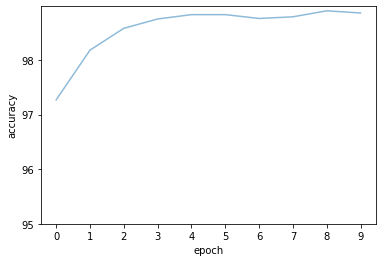

In [22]:
plot()

In [23]:
# model.load_state_dict(torch.load("cnn_model.pkl"))
torch.save(model.state_dict(), 'cnn_model.pkl')